**кластеризатор DBSCAN**

Евгений Борисов esborisov@sevsu.ru

In [1]:
import numpy as np
from numpy import random as rng
import numpy.ma as ma

import matplotlib.pyplot as plt

In [2]:
# from sklearn.datasets import make_blob

(1024, 2)

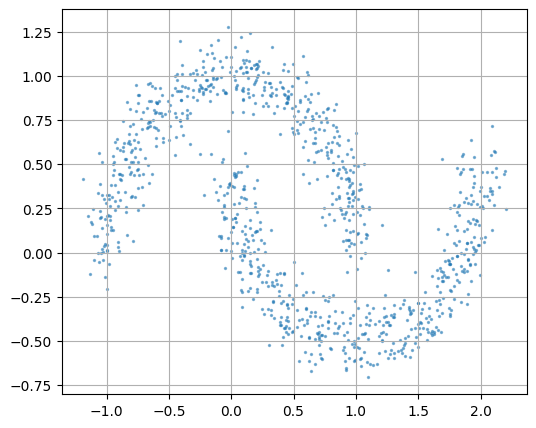

In [3]:
from sklearn.datasets import make_moons

X,_ = make_moons(n_samples=1024, noise=.1)
display(X.shape)

fig, ax = plt.subplots(figsize=(6,5))
ax.scatter( x=X[:,0], y=X[:,1], s=2, alpha=0.5 )
ax.grid()
plt.show()

In [4]:
# 1. выбираем рандомную точку из необработанных ;
#
# 2. формируем новый кластер радиуса R ;
#
# 3. если количество точек в кластере < K, 
#    то точки помечаются как шум, переход на п.1 ;
#
# 4. формируем подкластеры радиуса R вокруг каждой точки найденного кластера ;
#
# 5. проверяем все найденные подкластеры:
#    если количество точек в подкластере < K,
#    то точки помечаются как граничные
#    иначе помечаем точки как корневые и повторяем для каждой них рекуррентно п.4 

In [7]:
from sklearn.metrics.pairwise import euclidean_distances as metric

In [26]:
class DBScanClustering:
    
    def __init__(self,metric=metric,max_cluster_radius=.1,min_cluster_size=10):
        self._metric = metric
        self._radius = max_cluster_radius
        self._csize = min_cluster_size
        
    def fit(self,X): 
        return self
    
    def predict(self,X):
        result = { 'clusters': [], 'noise': set(), }
        D = self._metric(X) # матрица расстояний
        result = self._init_cluster(D,result)
        return result
    
    def _init_cluster(self,D,result):
        n = self._get_init_point(result,D.shape[0])
        if n<0: return result
        
        p_idx = np.unique( np.where( D[n,:]<self._radius )[0] )  # формируем кластер радиуса R вокруг центра n
        if len(p_idx)<self._csize: # мало точек в кластере
            result['noise'] = result['noise'].union([n]) # шумовые точки
            # выбираем новый центр, повторяем поиск
            return self._init_cluster(D,result)
        
        # формируем новый кластер
        result['clusters'].append( { 'core': set(), 'marginal': set(), } )
        return self._check_core(D,result,p_idx)
        
    
    @staticmethod
    def _get_init_point(result,max_index):
        if len(result['clusters'])<1: return rng.randint(max_index) # выбираем рандомную точку
        p_used = set.union(*[
                c['core'].union(c['marginal']) 
                for c in result['clusters'] 
            ]).union(result['noise'])
        p_free = set(range(max_index)) - p_used
        if len(p_free)>0: return rng.choice( np.array(list(p_free)) )
        return -1
                    
    def _check_core(self,D,result,p_idx):
        # формируем кластеры радиуса R вокруг центров из p_idx
        clusters_idx = [ 
            np.unique( np.where(D[c_idx,:]<self._radius)[0] ) 
            for c_idx in p_idx 
        ]
        
        assert len(clusters_idx)>0

        p_idx = [] # новые центры для проверки
        for c_idx in clusters_idx: # проверка кластера
            if len(c_idx)<self._csize: # мало точек в кластере
                result['clusters'][-1]['marginal'] = result['clusters'][-1]['marginal'].union(c_idx) # граничные точки
            else: # достаточно точек в кластере 
                core_new_idx = set(c_idx)- result['clusters'][-1]['core'] # новые точки в core
                result['clusters'][-1]['core'] = result['clusters'][-1]['core'].union(core_new_idx) # корневые точки
                p_idx.extend(list(core_new_idx)) # точки для проверки

        if len(p_idx)>0: return self._check_core(D,result,p_idx)
        
        return self._init_cluster(D,result) # нет новый точек для проверки

In [27]:
result = DBScanClustering().predict(X)

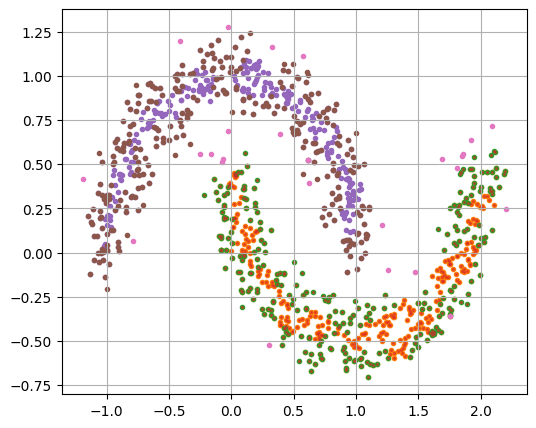

In [28]:
fig, ax = plt.subplots(figsize=(6,5))

for cluster in result['clusters']:
    core_idx = list(cluster['core'])
    marginal_idx = list(cluster['marginal'])
    ax.scatter( x=X[:,0], y=X[:,1], s=2, alpha=0.5 )
    ax.scatter( x=X[core_idx,0], y=X[core_idx,1], s=9 )
    ax.scatter( x=X[marginal_idx,0], y=X[marginal_idx,1], s=9 )
    
noise_idx = list(result['noise'])
ax.scatter( x=X[noise_idx,0], y=X[noise_idx,1], s=9 )
ax.grid()
plt.show()